In [ ]:
%tensorflow_version 2.x

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import sys
import os
sys.path.append('/content/gdrive/My Drive/W266-NLP/Project')
os.chdir('/content/gdrive/My Drive/W266-NLP/Project')
os.listdir()

In [14]:
import os
import time
import numpy as np
import pickle
import pandas as pd
import json
from pandas.io.json import json_normalize
from collections import Counter
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Attention
import nltk
from functools import reduce
!pip install wget
# Load PyDrive and Google Auth related packages
#!pip install -U -q PyDrive
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Attention
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import Input
from functools import reduce
flatten = lambda data: reduce(lambda x, y: x + y, data)
import glove_helper
!pip install tqdm
from tqdm import tqdm

# Load the json data
def load_json_file(name):
  """
  Load the json file and return a json object
  """
  with open(name,encoding='utf-8') as myfile:
    data = json.load(myfile)
    return data

# Convert json data object to a pandas data frame
def convert_to_pd(data):
    """
      Load the data to a pandas dataframe.
      Dataframe Columns:
      title
      para_index
      context
      q_index
      q_id
      q_isimpossible
      q_question
      q_anscount - number of answers
      q_answers - a list of object e.g [{ text: '', answer_start: 123}, ...]
    """
    result = []
    for pdata in data['data']:
        for para in pdata['paragraphs']:
            for q in para['qas']:
                result.append({
                                'title' : pdata['title'],
                                'context' : para['context'],
                                'q_id' : q['id'],
                                'q_isimpossible' : q['is_impossible'],
                                'q_question' : q['question'],
                                'q_anscount' : len(q['answers']),
                                'q_answers' : [a for a in q['answers']],
                                'q_answers_text': [a.get("text") for a in q['answers']],
                                'context_lowercase': para['context'].lower(),
                                'q_question_lowercase' : q['question'].lower(),
                                'q_answers_text_lowercase': [a.get("text").lower() for a in q['answers']]
                               })
    return pd.DataFrame.from_dict(result, orient='columns')

# Load the file from shareable google drive link and return a pandas dataframe
def loadDataFile(filename): 
    """
    Download a file from google drive with the shared link
    """ 
    data = load_json_file(filename)
    return convert_to_pd(data)

In [15]:
# DONOT RUN THIS ON COLAB#
#to make use of CPU and not GPU DONOT RUN THIS ON COLAB
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""


In [16]:
train_filename = 'train-v2.0.json'
dev_filename = 'dev-v2.0.json'

train_pd = loadDataFile(train_filename)
dev_pd = loadDataFile(dev_filename)

In [17]:
def get_c_q_a(dataset):
    q_id_list = []
    context_list =[]
    questions_list = []
    answers_list =[]
    q_impossible_list =[]
    for index,row in dataset.iterrows():
        q_id_list.append(row.q_id)
        context_list.append(row.context)
        questions_list.append(row.q_question)
        q_impossible_list.append(int(row.q_isimpossible))
        if len(row.q_answers_text)>0 :
            answers_list.append(row.q_answers_text[0])
        else:
            answers_list.append("")
    return [q_id_list,context_list,questions_list,q_impossible_list,answers_list]

train_lists = get_c_q_a(train_pd)
dev_lists = get_c_q_a(dev_pd)
context_maxlen = max(map(len, (x.split() for x in train_lists[1])))
question_maxlen = max(map(len, (x.split() for x in train_lists[2])))
answer_maxlen = max(map(len, (x.split() for x in train_lists[4])))
print("Max context length:",context_maxlen)
print("Max question length:",question_maxlen)
print("Max answer length:",answer_maxlen)

Max context length: 653
Max question length: 40
Max answer length: 43


In [18]:
context_maxlen = 250
question_maxlen = 20
answer_maxlen = 15
ndim = 100

In [19]:
def tokenize_c_q_a(dataset,num_words=None):
    tokenizer = Tokenizer(num_words,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"''",oov_token='<unk>')
    data = dataset[1]+dataset[2]+dataset[4]
    tokenizer.fit_on_texts(data)
    vocab = {}
    for word,i in tokenizer.word_index.items():
        if num_words is not None:
            if i <= num_words:
                vocab[word] = i
        else:
            vocab[word] = i
    #vocab = tokenizer.word_index
    vocab['<s>'] = len(vocab)+1
    vocab['</s>'] = len(vocab)+1
    id_vocab = {value: key for key, value in vocab.items()}
    return (tokenizer,vocab,id_vocab)

tokenizer_obj,vocab,id_vocab = tokenize_c_q_a(train_lists)

vocab_size = len(vocab)
print("Vocab Size:",vocab_size)

def calc_answer_span(context,answer):
    
    ans_len = len(answer)
    
    if ans_len!=0 and answer[0] in context:
        indices = [i for i, x in enumerate(context) if x == answer[0]]
        try:
            if(len(indices)>1):
                start = [i for i in indices if (context[i:i+ans_len] == answer) ]
                end = start[0] + ans_len - 1
                return (start[0],end)
            else:
                start = context.index(answer[0])
                end = start + ans_len - 1
                return (start,end)
        except:
            return (-1,-1)
    else:
        return (-1,-1)


def vectorize_data(tokenizer_obj,train_lists):
    qid_original = train_lists[0]
    context_seq = tokenizer_obj.texts_to_sequences(train_lists[1])
    question_seq = tokenizer_obj.texts_to_sequences(train_lists[2])
    answer_seq = tokenizer_obj.texts_to_sequences(train_lists[4])
    answer_span = [calc_answer_span(context_seq[i],answer_seq[i]) for i,x in enumerate(context_seq)]
    answer_start_index = [item[0] for item in answer_span]
    answer_end_index =  [item[1] for item in answer_span]
    answer_start_seq = []
    answer_end_seq = []
    for i,x in enumerate(answer_start_index):
        start = np.zeros(context_maxlen,dtype = "int32")
        end   = np.zeros(context_maxlen,dtype = "int32")
        #last space reserved for the question where there are no answers
        if (answer_start_index[i] < context_maxlen-1):
            start[answer_start_index[i]] = 1
        if (answer_end_index[i] < context_maxlen-1):
            end[answer_end_index[i]] = 1
        answer_start_seq.append(start)
        answer_end_seq.append(end)
        
    answer_input_seq = [[vocab['<s>']]+i+[vocab['</s>']] for i in answer_seq]
    answer_target_seq = [i+[vocab['</s>']] for i in answer_seq]
    context_seq_padded = pad_sequences(context_seq,context_maxlen-1,padding='post', truncating='post')
    #Adding 0 to last position special for no answer questions
    context_seq_padded = pad_sequences(context_seq_padded,context_maxlen,padding='post', truncating='post')
    question_seq_padded = pad_sequences(question_seq,question_maxlen,padding='post', truncating='post')
    answer_seq_padded = pad_sequences(answer_seq,answer_maxlen,padding='post', truncating='post')
    answer_input_seq_padded = pad_sequences(answer_input_seq,answer_maxlen+2,padding='post', truncating='post')
    answer_target_seq_padded = pad_sequences(answer_target_seq,answer_maxlen+2,padding='post', truncating='post')
    answer_impossible = np.array(train_lists[3])
    answer_start_seq_padded = pad_sequences(answer_start_seq,context_maxlen,padding='post', truncating='post') 
    answer_end_seq_padded = pad_sequences(answer_end_seq,context_maxlen,padding='post', truncating='post')
    #context_match_question = []
    #for i,a in enumerate(context_seq_padded):
    #    exact = [[1]if ecw in question_seq_padded[i] and ecw !=0 else [0] for ecw in a]
    #    context_match_question.append(exact)
    
    #context_match_question_padded = np.array(context_match_question)
    indices = np.arange(context_seq_padded.shape[0])
    np.random.seed(19)
    np.random.shuffle(indices)
    qid = [qid_original[i] for i in indices]
    context_seq_padded = context_seq_padded[indices]
    question_seq_padded = question_seq_padded[indices]
    answer_seq_padded = answer_seq_padded[indices]
    answer_input_seq_padded = answer_input_seq_padded[indices]
    answer_target_seq_padded = answer_target_seq_padded[indices]
    answer_impossible = answer_impossible[indices]
    answer_start_seq_padded = answer_start_seq_padded[indices]
    answer_end_seq_padded = answer_end_seq_padded[indices]
    #context_match_question_padded = context_match_question_padded[indices]
    train_samples = int(((context_seq_padded.shape[0]*.8)//128)*128)
    end_samples = int((context_seq_padded.shape[0]//128)*128)
    train_qid = qid[:train_samples]
    train_context_padded_seq = context_seq_padded[:train_samples]
    train_question_seq_padded = question_seq_padded[:train_samples]
    train_answer_seq_padded = answer_seq_padded[:train_samples]
    train_answer_input_seq_padded = answer_input_seq_padded[:train_samples]
    train_answer_target_seq_padded = answer_target_seq_padded[:train_samples]
    train_answer_impossible = answer_impossible[:train_samples]
    train_answer_start_seq_padded = answer_start_seq_padded[:train_samples]
    train_answer_end_seq_padded = answer_end_seq_padded[:train_samples]
    #train_context_match_question_padded = context_match_question_padded[:train_samples]
    val_qid = qid[train_samples:end_samples]
    val_context_padded_seq = context_seq_padded[train_samples:end_samples]
    val_question_seq_padded = question_seq_padded[train_samples:end_samples]
    val_answer_seq_padded = answer_seq_padded[train_samples:end_samples]
    val_answer_input_seq_padded = answer_input_seq_padded[train_samples:end_samples]
    val_answer_target_seq_padded = answer_target_seq_padded[train_samples:end_samples]
    val_answer_impossible = answer_impossible[train_samples:end_samples]
    val_answer_start_seq_padded = answer_start_seq_padded[train_samples:end_samples]
    val_answer_end_seq_padded = answer_end_seq_padded[train_samples:end_samples]
    #val_context_match_question_padded = context_match_question_padded[train_samples:end_samples]
    return (train_qid,train_context_padded_seq,train_question_seq_padded,train_answer_seq_padded,
            train_answer_input_seq_padded,train_answer_target_seq_padded,train_answer_impossible,
            train_answer_start_seq_padded,train_answer_end_seq_padded,
            #train_context_match_question_padded,
            val_qid,val_context_padded_seq,val_question_seq_padded,val_answer_seq_padded,
            val_answer_input_seq_padded,val_answer_target_seq_padded,val_answer_impossible,
            val_answer_start_seq_padded,val_answer_end_seq_padded
            #,val_context_match_question_padded
           )

train_qid,train_context_padded_seq,train_question_seq_padded,train_answer_seq_padded,\
train_answer_input_seq_padded,train_answer_target_seq_padded,train_answer_impossible,\
train_answer_start_seq_padded,train_answer_end_seq_padded,\
val_qid,val_context_padded_seq,val_question_seq_padded,val_answer_seq_padded,\
val_answer_input_seq_padded,val_answer_target_seq_padded,val_answer_impossible,\
val_answer_start_seq_padded,val_answer_end_seq_padded\
= vectorize_data(tokenizer_obj,train_lists)
print("validation num samples where answer impossible: ",len(val_answer_seq_padded[val_answer_impossible==1]))
print("validation num samples where answer not impossible: ",len(val_answer_seq_padded[val_answer_impossible==0]))
print("train num samples where answer impossible: ",len(train_answer_seq_padded[train_answer_impossible==1]))
print("train num samples where answer not impossible: ",len(train_answer_seq_padded[train_answer_impossible==0]))

Vocab Size: 88701
validation num samples where answer impossible:  8730
validation num samples where answer not impossible:  17382
train num samples where answer impossible:  34761
train num samples where answer not impossible:  69431


In [20]:
def create_embedding_matrix(word_index,vocab_size=50000,ndim=100):
    hands = glove_helper.Hands(ndim)
    embedding_matrix = np.zeros((vocab_size+1,ndim))
    for word,i in word_index.items():
        if i<=vocab_size:
            embedding_vector = hands.get_vector(word,strict=False)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_matrix = create_embedding_matrix(vocab,vocab_size,ndim)

Loading vectors from data/glove/glove.6B.zip
Parsing file: data/glove/glove.6B.zip:glove.6B.100d.txt
Found 400,000 words.
Parsing vectors... Done! (W.shape = (400003, 100))


In [21]:
embedding_matrix.shape

(88702, 100)

In [22]:
#New Model with attention in every step of the answer decoder
class BahdanauAttention_model2(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention_model2, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
                                self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

# Answer Module which is custom as we need to feed output of each time sequence with attention to next 
# time sequence
class answer_module(tf.keras.Model):
    def __init__(self,embedding_matrix,
                      vocab_size,
                      ndim,
                      num_unit_gru,
                      num_layers_gru,
                      dropout_rate,
                      l1_regularizer_weight = .01,
                      l2_regularizer_weight = .01
                      ):
        super(answer_module, self).__init__()
        self.num_unit_gru = num_unit_gru
        self.dropout_rate = dropout_rate
        self.WSTART = tf.keras.layers.Dense(2*self.num_unit_gru)
        self.WEND = tf.keras.layers.Dense(2*self.num_unit_gru)        
    
    def call(self,
             question,
             context):
        
        context = tf.transpose(context,[0,2,1])
        ################ start prediction logit ######################
        start = self.WSTART(question)
        hidden_start_time_axis = tf.expand_dims(start, 1)
        
        start_logit = tf.squeeze(tf.matmul(hidden_start_time_axis,context),axis=1)
        start_logit = tf.math.exp(start_logit)
            
        ################ end prediction logit ######################
        end = self.WEND(question)

        hidden_end_time_axis = tf.expand_dims(end, 1)
        
        # squeeze remooves time slice we added before
        # final shape = (batch_size,decoder_timesteps)
        end_logit = tf.squeeze(tf.matmul(hidden_end_time_axis,context),axis=1)
        end_logit = tf.math.exp(end_logit)
        
        
        return start_logit,end_logit 

#Encoder Module which combines the context,question into episodic memory and emits context outputs and 
#question outputs
class encoder_module(tf.keras.Model):    
    def __init__(self,embedding_matrix,
                      vocab_size,
                      max_context_length,
                      max_question_length,
                      max_answer_length,
                      num_unit_gru = 64,
                      num_layers_gru = 2,
                      ndim =100,
                      num_episodes = 2,
                      dropout_rate = 0.5,
                      num_episodic_network_unit = 64,
                      l1_regularizer_weight = .01,
                      l2_regularizer_weight = .01
                      ):
        super(encoder_module, self).__init__()
        #Context Module
        self.num_unit_gru = num_unit_gru
        self.dropout_rate = dropout_rate
        self.num_layers_gru = num_layers_gru
        self.embedding_matrix = embedding_matrix
        self.vocab_size = vocab_size
        self.ndim = ndim
        self.max_context_length = max_context_length
        self.max_question_length = max_question_length
        self.max_answer_length = max_answer_length
        self.num_episodes = num_episodes
        self.num_episodic_network_unit = num_episodic_network_unit
        self.context_embeddings_layer = layers.Embedding(self.vocab_size+1,
                                                         self.ndim,
                                                         mask_zero=True,
                                                         weights =[self.embedding_matrix],
                                                         trainable = False,
                                                         name='Context_Embedding')
        self.context_output_layers = []
        self.context_batch_normalization_layers = []
        for i in range(self.num_layers_gru):
            self.context_output_layers.append(layers.Bidirectional(
                                                layers.GRU(self.num_unit_gru,
                                                           dropout=self.dropout_rate,
                                                           recurrent_dropout= self.dropout_rate,
                                                           recurrent_initializer='glorot_uniform',
                                                           return_sequences=True,
                                                           kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                              l1_regularizer_weight,
                                                                              l2_regularizer_weight),
                                                           bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                              l1_regularizer_weight,
                                                                              l2_regularizer_weight)),
                                                           merge_mode='concat',
                                                           name='Context_Bid_Layer'+str(i))
                                              )
            self.context_batch_normalization_layers.append(layers.BatchNormalization())
        
        #Question Module
        self.question_embeddings_layer = layers.Embedding(self.vocab_size+1,
                                                          self.ndim,
                                                          mask_zero=True,
                                                          weights =[self.embedding_matrix],
                                                          trainable = False,
                                                          name='Question_Embedding')
          
        self.question_output_layers = []
        self.question_batch_normalization_layers = []
        for i in range(num_layers_gru):
            self.question_output_layers.append(layers.Bidirectional(
                                                 layers.GRU(self.num_unit_gru,
                                                            dropout=self.dropout_rate,
                                                            recurrent_dropout= self.dropout_rate,
                                                            recurrent_initializer='glorot_uniform',
                                                            return_sequences=True,
                                                            kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                                l1_regularizer_weight,
                                                                                l2_regularizer_weight),
                                                            bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                                l1_regularizer_weight,
                                                                                l2_regularizer_weight)),
                                                             merge_mode='concat',
                                                             name='Question_Bid_Layer'+str(i))
                                              )
            self.question_batch_normalization_layers.append(layers.BatchNormalization())
            
        self.question_attention_layer = layers.Dense(1)
        #Episodic Memory 
        #self.episodic_weight_layer = layers.Dense(self.num_unit_gru,use_bias=False)
        #self.episodic_tanh_layer = layers.Dense(self.num_episodic_network_unit,activation='tanh')
        #self.episodic_score_layer = layers.Dense(1)
        #Self alignment
        self.Align_W1 = tf.keras.layers.Dense(1,activation="relu")
        self.Align_W2 = tf.keras.layers.Dense(1,activation="relu")
    def call(self,context_input,question_input):
        #context Module
        context_embeddings = self.context_embeddings_layer(context_input)
        #Question Module
        question_embeddings = self.question_embeddings_layer(question_input)
        #self alignment
        context_relu = self.Align_W1(context_embeddings)
        question_relu = self.Align_W2(question_embeddings)
        self_align_logits = tf.matmul(context_relu,tf.transpose(question_relu,[0,2,1]))
        self_align_scores = tf.nn.softmax(self_align_logits)
        self_align_embeddings = tf.matmul(self_align_scores,question_embeddings)
        context_concat_embeddings = tf.concat(values=[context_embeddings,self_align_embeddings],axis=-1)
        
        #print("context_embeddings.shape:",context_embeddings.shape)
        #print("question_embeddings.shape:",question_embeddings.shape)
        #print("context_relu.shape:",context_relu.shape)
        #print("question_relu.shape:",question_relu.shape)
        #print("self_align_logits.shape:",self_align_logits.shape)
        #print("self_align_scores.shape:",self_align_scores.shape)
        #print("self_align_embeddings.shape:",self_align_embeddings.shape)
        #print("context_concat_embeddings.shape:",context_concat_embeddings.shape)
        for i in range(len(self.context_output_layers)):
            if i==0:
                context_outputs = self.context_output_layers[i](context_concat_embeddings)
            else:
                context_outputs = self.context_output_layers[i](context_outputs)
            context_outputs = self.context_batch_normalization_layers[i](context_outputs)

        
        for i in range(len(self.question_output_layers)):
            if i==0:
                question_outputs = self.question_output_layers[i](question_embeddings)
            else:
                question_outputs = self.question_output_layers[i](question_outputs)
            question_outputs = self.question_batch_normalization_layers[i](question_outputs) 
        
        #Calculate the self attention for question        
        question_score = self.question_attention_layer(question_outputs)
        # attention_weights shape == (batch_size, max_length, 1)
        question_attention_weights = tf.nn.softmax(question_score, axis=1)
        question_outputs = question_attention_weights * question_outputs
        question_outputs = tf.reduce_sum(question_outputs, axis=1)
        
        #Episodic Memory 
        #m = tf.identity(question_outputs)
        #for i in range(self.num_episodes):
        #    m_increased = tf.tile(tf.keras.backend.expand_dims(m,1),
        #                          tf.constant([1,self.max_context_length,1],tf.int32))
        #    q_increased = tf.tile(tf.keras.backend.expand_dims(question_outputs,1),
        #                          tf.constant([1,self.max_context_length,1],tf.int32))
        #    c_mul_q = layers.multiply([context_outputs,q_increased])
        #    c_mul_m = layers.multiply([context_outputs,m_increased])
        #    c_minus_q =tf.keras.backend.abs(layers.subtract([context_outputs,q_increased]))
        #    c_minus_m = tf.keras.backend.abs(layers.subtract([context_outputs,m_increased]))
        #    c_dot_q = tf.matmul(tf.keras.backend.expand_dims(self.episodic_weight_layer(question_outputs),1), 
        #                        context_outputs,
        #                        transpose_b=True)
        #    c_dot_q = layers.Permute((2,1))(c_dot_q)
        #    c_dot_m = tf.matmul(tf.keras.backend.expand_dims(self.episodic_weight_layer(m),1), 
        #                        context_outputs,transpose_b=True)
        #    c_dot_m = layers.Permute((2,1))(c_dot_m)
        #    z = tf.concat([context_outputs,
        #                            m_increased,
        #                            q_increased,
        #                            c_mul_q,
        #                            c_mul_m,
        #                            c_minus_q,
        #                            c_minus_m,
        #                            c_dot_q,
        #                            c_dot_m],axis=-1)
        #    score = self.episodic_score_layer(self.episodic_tanh_layer(z))
        #    attention_weights = tf.nn.softmax(score, axis=1)
        #    m_value = attention_weights * context_outputs
        #    m = tf.reduce_sum(m_value, axis=1)
        #concatenate episodic memory with question
        #concatenated_tensor = tf.concat(values=[m,question_outputs],axis=1)
        return (question_outputs,context_outputs)
    
                
#Function to create the Models
def create_models(embedding_matrix,
                  max_context_length,
                  max_question_length,
                  max_answer_length,
                  num_unit_gru = 64,
                  num_layers_gru = 2,
                  ndim =100,
                  num_episodes = 2,
                  num_dense_layer_feasibility_units = 16,
                  dropout_rate = 0.5,
                  num_dense_layers_feasibility = 1,
                  num_episodic_network_unit = 64,
                  l1_regularizer_weight = .01,
                  l2_regularizer_weight = .01):
    """
    
    def create_episodic_memory(num_episodes,
                               query,
                               context_outputs,
                               max_context_length,
                               max_question_length,
                               num_episodic_network_unit):
        m = layers.Lambda(lambda x: x)(query)
        weight_layer = layers.Dense(query.shape[1],use_bias=False)
        for i in range(num_episodes):
            m_increased = tf.tile(tf.keras.backend.expand_dims(m,1),
                                  tf.constant([1,max_context_length,1],tf.int32))
            q_increased = tf.tile(tf.keras.backend.expand_dims(query,1),
                                  tf.constant([1,max_context_length,1],tf.int32))
            c_mul_q = layers.multiply([context_outputs,q_increased])
            c_mul_m = layers.multiply([context_outputs,m_increased])
            c_minus_q =tf.keras.backend.abs(layers.subtract([context_outputs,q_increased]))
            c_minus_m = tf.keras.backend.abs(layers.subtract([context_outputs,m_increased]))
            c_dot_q = tf.matmul(tf.keras.backend.expand_dims(weight_layer(query),1), 
                                context_outputs,transpose_b=True)
            c_dot_q = layers.Permute((2,1))(c_dot_q)
            c_dot_m = tf.matmul(tf.keras.backend.expand_dims(weight_layer(m),1), 
                                context_outputs,transpose_b=True)
            c_dot_m = layers.Permute((2,1))(c_dot_m)
            z = layers.concatenate([context_outputs,
                                    m_increased,
                                    q_increased,
                                    c_mul_q,
                                    c_mul_m,
                                    c_minus_q,
                                    c_minus_m,
                                    c_dot_q,
                                    c_dot_m],axis=-1)
            score = layers.Dense(1)(layers.Dense(num_episodic_network_unit,activation='tanh')(z))
            attention_weights = tf.nn.softmax(score, axis=1)
            m_value = attention_weights * context_outputs
            m = tf.reduce_sum(m_value, axis=1)
        return m
    
    
    #Input Module
    context_input = Input(shape=(None,),dtype='int32',name='Context_Input')
    context_embeddings = layers.Embedding(vocab_size+1,
                                          ndim,
                                          mask_zero=True,
                                          name='Context_Embedding')(context_input)

    for i in range(num_layers_gru):
        context_outputs_layers = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                                 dropout=dropout_rate,
                                                                 recurrent_dropout= dropout_rate,
                                                                 recurrent_initializer='glorot_uniform',
                                                                 return_sequences=True),
                                                      merge_mode='sum',
                                                      name='Context_Bid_Layer'+str(i))
        if i==0:
            context_outputs = context_outputs_layers(context_embeddings)
        else:
            context_outputs = context_outputs_layers(context_outputs)
        context_outputs = layers.BatchNormalization()(context_outputs)
    print("Context output shape",context_outputs.shape)
    #Question Module
    question_input = Input(shape=(None,),dtype='int32',name='Question_Input')
    question_embeddings = layers.Embedding(vocab_size+1,
                                           ndim,
                                           mask_zero=True,
                                           name='Question_Embedding')(question_input)

    for i in range(num_layers_gru):
        if i==0 and num_layers_gru >1:
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                               dropout=dropout_rate,
                                                               recurrent_dropout= dropout_rate,
                                                               recurrent_initializer='glorot_uniform',
                                                               return_sequences=True),
                                                    merge_mode='sum',
                                                    name='Question_Bid_Layer'+str(i))(question_embeddings)
        elif i==0 and num_layers_gru ==1:
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                               dropout=dropout_rate,
                                                               recurrent_dropout= dropout_rate,
                                                               recurrent_initializer='glorot_uniform',
                                                               return_sequences=False),
                                                    merge_mode='sum',
                                                    name='Question_Bid_Layer'+str(i))(question_embeddings)
        elif i==(num_layers_gru-1):
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                               dropout=dropout_rate,
                                                               recurrent_dropout= dropout_rate,
                                                               recurrent_initializer='glorot_uniform',
                                                               return_sequences=False),
                                                    merge_mode='sum',
                                                    name='Question_Bid_Layer'+str(i))(question_outputs)
        else:
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                               dropout=dropout_rate,
                                                               recurrent_dropout= dropout_rate,
                                                               recurrent_initializer='glorot_uniform',
                                                               return_sequences=True),
                                                    merge_mode='sum',
                                                    name='Question_Bid_Layer'+str(i))(question_outputs)
        question_outputs = layers.BatchNormalization()(question_outputs)
    #Episodic Memory Module
    m=create_episodic_memory(num_episodes,
                             question_outputs,
                             context_outputs,
                             max_context_length,
                             max_question_length,
                             num_episodic_network_unit)

    concatenated_tensor = layers.concatenate(inputs=[m,question_outputs],
                                             name='Concatenation_Memory_Question',axis=1)
    """
    #encoder Model
    encoder_model = encoder_module(embedding_matrix,
                                   vocab_size,
                                   max_context_length,
                                   max_question_length,
                                   max_answer_length,
                                   num_unit_gru,
                                   num_layers_gru,
                                   ndim,
                                   num_episodes,
                                   dropout_rate,
                                   num_episodic_network_unit,
                                   l1_regularizer_weight = l1_regularizer_weight,
                                   l2_regularizer_weight = l2_regularizer_weight
                                 )
    
    
    #Model([context_input,question_input], [m,concatenated_tensor,question_outputs,context_outputs])
    #answer_module
    answer_model = answer_module(embedding_matrix,
                                 vocab_size,
                                 ndim,
                                 num_unit_gru,
                                 num_layers_gru,
                                 dropout_rate,
                                 l1_regularizer_weight = l1_regularizer_weight,
                                 l2_regularizer_weight = l2_regularizer_weight)
    #encoder_model.get_layer("Question_Embedding").set_weights([embedding_matrix])
    #encoder_model.get_layer("Question_Embedding").trainable = False
    #encoder_model.get_layer("Context_Embedding").set_weights([embedding_matrix])
    #encoder_model.get_layer("Context_Embedding").trainable = False
    
    #feasibility module
    #feasibility_episodic_memory_input = Input(shape=(num_unit_gru,), name="FeasibilityEpisodicMemoryInput")
    feasibility_start_logits_input = Input(shape=(max_context_length,),name="FeasibilityStartLogitInput")
    feasibility_end_logits_input = Input(shape=(max_context_length),name="FeasibilityEndLogitInput")
    feasibility_context_input = Input(shape=(None,2*num_unit_gru,),name='feasibilityContext_Input')
    feasibility_question_input = Input(shape=(2*num_unit_gru,),name='feasibilityQuestion_Input')
    #create attention between Context and Question
    #q_with_time_axis = tf.keras.backend.expand_dims(feasibility_question_input,1)
    #attentionContextQuestion = layers.AdditiveAttention()([q_with_time_axis,
    #                                                      feasibility_context_input])
    #attentionContextQuestionReduced = tf.keras.backend.sum(attentionContextQuestion, axis=1)
    #create Episodic memory 
    #Episodic Memory 
    episodic_weight_layer = layers.Dense(2*num_unit_gru,use_bias=False)
    episodic_tanh_layer = layers.Dense(num_episodic_network_unit,activation='tanh')
    episodic_score_layer = layers.Dense(1)
    m = tf.identity(feasibility_question_input)
    for i in range(num_episodes):
        m_increased = tf.tile(tf.keras.backend.expand_dims(m,1),
                              tf.constant([1,max_context_length,1],tf.int32))
        q_increased = tf.tile(tf.keras.backend.expand_dims(feasibility_question_input,1),
                              tf.constant([1,max_context_length,1],tf.int32))
        c_mul_q = layers.multiply([feasibility_context_input,q_increased])
        c_mul_m = layers.multiply([feasibility_context_input,m_increased])
        c_minus_q =tf.keras.backend.abs(layers.subtract([feasibility_context_input,q_increased]))
        c_minus_m = tf.keras.backend.abs(layers.subtract([feasibility_context_input,m_increased]))
        c_dot_q = tf.matmul(tf.keras.backend.expand_dims(episodic_weight_layer(feasibility_question_input),1), 
                            feasibility_context_input,
                            transpose_b=True)
        c_dot_q = layers.Permute((2,1))(c_dot_q)
        c_dot_m = tf.matmul(tf.keras.backend.expand_dims(episodic_weight_layer(m),1), 
                            feasibility_context_input,transpose_b=True)
        c_dot_m = layers.Permute((2,1))(c_dot_m)
        z = tf.concat([feasibility_context_input,
                                m_increased,
                                q_increased,
                                c_mul_q,
                                c_mul_m,
                                c_minus_q,
                                c_minus_m,
                                c_dot_q,
                                c_dot_m],axis=-1)
        score = episodic_score_layer(episodic_tanh_layer(z))
        attention_weights = tf.nn.softmax(score, axis=1)
        m_value = attention_weights * feasibility_context_input
        m = tf.reduce_sum(m_value, axis=1)
    
    
    feasibility_dense_input = tf.concat([m,
                                         feasibility_start_logits_input,
                                         feasibility_end_logits_input],
                                        axis=-1)
    for i in range(num_dense_layers_feasibility):        
        if i==0:
            dense_layer = layers.Dense(num_dense_layer_feasibility_units,
                                       activation='relu',
                                       name='feasibility_layer_'+str(i),
                                       kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight),
                                        bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight)
                                      )(feasibility_dense_input)
        else:
            dense_layer = layers.Dense(num_dense_layer_feasibility_units,
                                       activation='relu',
                                       name='feasibility_layer_'+str(i),
                                       kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight),
                                        bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight)
                                      )(dense_layer)
        dense_layer = layers.BatchNormalization()(dense_layer)
        dropout_layer = layers.Dropout(dropout_rate,name='feasibility_drop_'+str(i))(dense_layer)

    feasibility_output = layers.Dense(1,activation='sigmoid',
                                      name='feasibility_output',
                                      kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                    l1_regularizer_weight,
                                                                    l2_regularizer_weight),
                                      bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                    l1_regularizer_weight,
                                                                    l2_regularizer_weight))(dropout_layer)
    feasibility_model = Model([feasibility_question_input,
                               feasibility_context_input,
                               feasibility_start_logits_input,
                               feasibility_end_logits_input],
                               feasibility_output)
    
    return (answer_model,encoder_model,feasibility_model)

In [23]:
#Function to get sentences from the predicted answers
def decode_sentence(context_input_seq,
                     question_input_seq,
                     encoder_model,
                     answer_model):
    decoded_sentence = ""
    question_output,context_output = encoder_model(context_input_seq,question_input_seq) 
    
    start_logits,end_logits = answer_model(question_output,context_output)
    
    #Do a outer matrix multiplication of the logits 
    # we need to get the start and end index with highest multiplication of start and end probs
    outer = tf.matmul(tf.expand_dims(start_logits, axis=2),tf.expand_dims(end_logits, axis=0)) 
    outer = tf.linalg.band_part(outer, 0, answer_maxlen)
    start_position = tf.argmax(tf.reduce_max(outer, axis=2),axis=1)    
    end_position = tf.argmax(tf.reduce_max(outer, axis=1),axis=1)
    #print(start_position.shape)
    #print(end_position.shape)
    #print(start_position)
    #print(end_position)
    
    for i in range(start_position[0],end_position[0]+1):
        sampled_token_index = context_input_seq[0,i]
        if sampled_token_index == 0:
            sampled_char = ""
        else:
            sampled_char = id_vocab[sampled_token_index]
        if i == start_position[0]:
            decoded_sentence += sampled_char
        else:
            decoded_sentence += " "+sampled_char
    return decoded_sentence

In [24]:
Experiment_Dic = {'Experiment0': {'num_unit_gru': 64,
                                  'num_layers_gru': 2,
                                  'num_episodes': 3,
                                  'num_dense_layer_feasibility_units': 32,
                                  'dropout_rate': 0.6,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 192,
                                  'learning_rate': 0.001,
                                  'l1_regularizer_weight':0.01,
                                  'l2_regularizer_weight':0.01},
                  'Experiment1': {'num_unit_gru': 80,
                                  'num_layers_gru': 2,
                                  'num_episodes': 2,
                                  'num_dense_layer_feasibility_units': 64,
                                  'dropout_rate': 0.7,
                                  'num_dense_layers_feasibility': 3,
                                  'num_episodic_network_unit': 192,
                                  'learning_rate': 0.005,
                                  'l1_regularizer_weight':0.0001,
                                  'l2_regularizer_weight':0.01},
                  'Experiment2': {'num_unit_gru': 100,
                                  'num_layers_gru': 2,
                                  'num_episodes': 3,
                                  'num_dense_layer_feasibility_units': 64,
                                  'dropout_rate': 0.5,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 64,
                                  'learning_rate': 0.005,
                                  'l1_regularizer_weight':0.01,
                                  'l2_regularizer_weight':0.01},
                  'Experiment3': {'num_unit_gru': 80,
                                  'num_layers_gru': 2,
                                  'num_episodes': 2,
                                  'num_dense_layer_feasibility_units': 32,
                                  'dropout_rate': 0.7,
                                  'num_dense_layers_feasibility': 3,
                                  'num_episodic_network_unit': 192,
                                  'learning_rate': 0.005,
                                  'l1_regularizer_weight':0.01,
                                  'l2_regularizer_weight':0.0001},
                  'Experiment4': {'num_unit_gru': 80,
                                  'num_layers_gru': 2,
                                  'num_episodes': 2,
                                  'num_dense_layer_feasibility_units': 48,
                                  'dropout_rate': 0.6,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 128,
                                  'learning_rate': 0.005,
                                  'l1_regularizer_weight':0.001,
                                  'l2_regularizer_weight':0.001},
                  'Experiment5': {'num_unit_gru': 80,
                                  'num_layers_gru': 2,
                                  'num_episodes': 3,
                                  'num_dense_layer_feasibility_units': 64,
                                  'dropout_rate': 0.5,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 192,
                                  'learning_rate': 0.005,
                                  'l1_regularizer_weight':0.001,
                                  'l2_regularizer_weight':0.0001},
                  'Experiment6': {'num_unit_gru': 64,
                                  'num_layers_gru': 1,
                                  'num_episodes': 1,
                                  'num_dense_layer_feasibility_units': 64,
                                  'dropout_rate': 0.5,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 80,
                                  'learning_rate': 0.001,
                                  'l1_regularizer_weight':0.01,
                                  'l2_regularizer_weight':0.01}
                }
Experiment_Dic

{'Experiment0': {'num_unit_gru': 64,
  'num_layers_gru': 2,
  'num_episodes': 3,
  'num_dense_layer_feasibility_units': 32,
  'dropout_rate': 0.6,
  'num_dense_layers_feasibility': 1,
  'num_episodic_network_unit': 192,
  'learning_rate': 0.001,
  'l1_regularizer_weight': 0.01,
  'l2_regularizer_weight': 0.01},
 'Experiment1': {'num_unit_gru': 80,
  'num_layers_gru': 2,
  'num_episodes': 2,
  'num_dense_layer_feasibility_units': 64,
  'dropout_rate': 0.7,
  'num_dense_layers_feasibility': 3,
  'num_episodic_network_unit': 192,
  'learning_rate': 0.005,
  'l1_regularizer_weight': 0.0001,
  'l2_regularizer_weight': 0.01},
 'Experiment2': {'num_unit_gru': 100,
  'num_layers_gru': 2,
  'num_episodes': 3,
  'num_dense_layer_feasibility_units': 64,
  'dropout_rate': 0.5,
  'num_dense_layers_feasibility': 1,
  'num_episodic_network_unit': 64,
  'learning_rate': 0.005,
  'l1_regularizer_weight': 0.01,
  'l2_regularizer_weight': 0.01},
 'Experiment3': {'num_unit_gru': 80,
  'num_layers_gru': 2,

In [28]:
def run_experiments(Experiment_Dic,
                    Experiment_No,
                    embedding_matrix,
                    ndim = 100,
                    tpu_enabled=0,
                    num_training_samples=1024,
                    num_validation_samples = 256,
                    num_epochs = 50,
                    batch_size = 10):
    num_training_samples = int((num_training_samples//128)*128)
    num_validation_samples = int((num_validation_samples//128)*128)
    #get the experiment details
    ExperimentNo = 'Experiment'+str(Experiment_No)
    num_unit_gru = Experiment_Dic[ExperimentNo]['num_unit_gru']
    num_layers_gru = Experiment_Dic[ExperimentNo]['num_layers_gru']
    num_episodes = Experiment_Dic[ExperimentNo]['num_episodes']
    num_dense_layer_feasibility_units = Experiment_Dic[ExperimentNo]['num_dense_layer_feasibility_units']
    dropout_rate = Experiment_Dic[ExperimentNo]['dropout_rate']
    num_dense_layers_feasibility = Experiment_Dic[ExperimentNo]['num_dense_layers_feasibility']
    num_episodic_network_unit = Experiment_Dic[ExperimentNo]['num_episodic_network_unit']
    learning_rate = Experiment_Dic[ExperimentNo]['learning_rate']
    l1_regularizer_weight = Experiment_Dic[ExperimentNo]['l1_regularizer_weight']
    l2_regularizer_weight = Experiment_Dic[ExperimentNo]['l2_regularizer_weight']
        
    if tpu_enabled==0:
        #When GPU ENABLED
        answer_model,\
        encoder_model,\
        feasibility_model = create_models(
                                      embedding_matrix = embedding_matrix,
                                      max_context_length = context_maxlen,
                                      max_question_length = question_maxlen,
                                      max_answer_length = answer_maxlen,
                                      num_unit_gru = num_unit_gru,
                                      num_layers_gru = num_layers_gru,
                                      ndim =ndim,
                                      num_episodes = num_episodes,
                                      num_dense_layer_feasibility_units = num_dense_layer_feasibility_units,
                                      dropout_rate = dropout_rate,
                                      num_dense_layers_feasibility = num_dense_layers_feasibility,
                                      num_episodic_network_unit = num_episodic_network_unit,
                                      l1_regularizer_weight = l1_regularizer_weight,
                                      l2_regularizer_weight = l2_regularizer_weight)

        adam_optim = keras.optimizers.Adam(learning_rate=learning_rate)
        #encoder_model.compile(optimizer=adam_optim,
        #                      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        #                      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
        #encoder_model.summary()
        #answer_model.compile(optimizer=adam_optim,
        #                           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        #                           metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
        #                        )
        #
        #answer_model.summary()
        feasibility_model.compile(optimizer=adam_optim,
                                   loss=tf.keras.losses.BinaryCrossentropy(),
                                   metrics=[tf.keras.metrics.BinaryAccuracy()]
                                   )
        #feasibility_model.summary()
    else: 
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' +
                                                                     os.environ['COLAB_TPU_ADDR'])
        tf.config.experimental_connect_to_cluster(resolver)
        tf.tpu.experimental.initialize_tpu_system(resolver)
        strategy = tf.distribute.experimental.TPUStrategy(resolver)
        batch_size = 128*8
        with strategy.scope():
            answer_model,\
            encoder_model,\
            feasibility_model = create_models(
                                          embedding_matrix = embedding_matrix,
                                          max_context_length = context_maxlen,
                                          max_question_length = question_maxlen,
                                          max_answer_length = answer_maxlen,
                                          num_unit_gru = num_unit_gru,
                                          num_layers_gru = num_layers_gru,
                                          ndim =ndim,
                                          num_episodes = num_episodes,
                                          num_dense_layer_feasibility_units = 
                                                        num_dense_layer_feasibility_units,
                                          dropout_rate = dropout_rate,
                                          num_dense_layers_feasibility = num_dense_layers_feasibility,
                                          num_episodic_network_unit = num_episodic_network_unit,
                                         l1_regularizer_weight = l1_regularizer_weight,
                                         l2_regularizer_weight = l2_regularizer_weight)

            adam_optim = keras.optimizers.Adam(learning_rate=learning_rate)
            #encoder_model.compile(optimizer=adam_optim,
            #                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            #                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
            #encoder_model.summary()
            #
            #answer_model.compile(optimizer=adam_optim,
            #                           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            #                           metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
            #                    )

            #answer_model.summary()
            feasibility_model.compile(optimizer=adam_optim,
                                       loss=tf.keras.losses.BinaryCrossentropy(),
                                       metrics=[tf.keras.metrics.BinaryAccuracy()]
                                       )
            #feasibility_model.summary()
    #Train the Answer Model and Encoder Model
    answer_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    answer_loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction='none')
    train_acc_metric = keras.metrics.CategoricalAccuracy()
    val_acc_metric = keras.metrics.CategoricalAccuracy()
    @tf.function
    def answer_loss_function(real_start, real_end,pred_start,pred_end):
        
        start_loss = answer_loss_object(real_start,pred_start)
        end_loss = answer_loss_object(real_end,pred_end)
        return tf.reduce_mean(start_loss+end_loss)

    @tf.function
    def answer_train_step(inp,ques,targ_start,targ_end,encoder_model,answer_model):
        loss = 0
        batch_loss = 0
        with tf.GradientTape() as tape:
            question_output,context_output = encoder_model(inp,ques)
            start_logits,end_logits = answer_model(question_output,context_output)
            loss += answer_loss_function(targ_start,targ_end,start_logits,end_logits)
            batch_loss = loss
            train_acc_metric(targ_start,start_logits)
            train_acc_metric(targ_end,end_logits)
            variables = encoder_model.trainable_variables + answer_model.trainable_variables
            gradients = tape.gradient(loss, variables)
            answer_optimizer.apply_gradients(zip(gradients, variables))
        return batch_loss

    @tf.function
    def answer_val_step(inp,ques,targ_start,targ_end,encoder_model,answer_model):
        loss = 0
        question_output,context_output = encoder_model(inp,ques)
        start_logits,end_logits = answer_model(question_output,context_output)
        loss += answer_loss_function(targ_start,targ_end,start_logits,end_logits)
        batch_loss = loss
        val_acc_metric(targ_start,start_logits)
        val_acc_metric(targ_end,end_logits)
        
        return batch_loss
    #Create batches for training only include where its possible to answer
    #
    #c = b==1
    #a[c][:3]
    train_ans_cond = train_answer_impossible==0
    val_ans_cond = val_answer_impossible==0
    #make sure that training samples and validation samples are divisible by 1024
    num_training_samples_upd = int((train_context_padded_seq[train_ans_cond][:num_training_samples].shape[0]//1024)
                                   *1024)
    
    num_validation_samples_upd = int((val_context_padded_seq[val_ans_cond][:num_validation_samples].shape[0]//1024)
                                   *1024)
    TRAIN_BUFFER_SIZE = train_context_padded_seq[train_ans_cond][:num_training_samples_upd].shape[0]
    VAL_BUFFER_SIZE = val_context_padded_seq[val_ans_cond][:num_validation_samples_upd].shape[0]
    steps_per_epoch = TRAIN_BUFFER_SIZE//batch_size
    steps_per_epoch_val = VAL_BUFFER_SIZE//batch_size
    train_dataset = tf.data.Dataset.from_tensor_slices((train_context_padded_seq[train_ans_cond][:num_training_samples_upd],
                                                        train_question_seq_padded[train_ans_cond][:num_training_samples_upd],
                                                        train_answer_seq_padded[train_ans_cond][:num_training_samples_upd],
                                                        train_answer_input_seq_padded[train_ans_cond][:num_training_samples_upd],
                                                        train_answer_target_seq_padded[train_ans_cond][:num_training_samples_upd],
                                                        train_answer_impossible[train_ans_cond][:num_training_samples_upd],
                                                        train_answer_start_seq_padded[train_ans_cond][:num_training_samples_upd],
                                                        train_answer_end_seq_padded[train_ans_cond][:num_training_samples_upd]
                                                       ))\
                                   .shuffle(TRAIN_BUFFER_SIZE,reshuffle_each_iteration=True)
    train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_context_padded_seq[val_ans_cond][:num_validation_samples_upd],
                                                      val_question_seq_padded[val_ans_cond][:num_validation_samples_upd],
                                                      val_answer_seq_padded[val_ans_cond][:num_validation_samples_upd],
                                                      val_answer_input_seq_padded[val_ans_cond][:num_validation_samples_upd],
                                                      val_answer_target_seq_padded[val_ans_cond][:num_validation_samples_upd],
                                                      val_answer_impossible[val_ans_cond][:num_validation_samples_upd],
                                                      val_answer_start_seq_padded[val_ans_cond][:num_validation_samples_upd],
                                                      val_answer_end_seq_padded[val_ans_cond][:num_validation_samples_upd]
                                                     ))
    val_dataset = val_dataset.batch(batch_size,drop_remainder=True)
    
    #Run Epochs
    
    history_answer_model = {'loss':[],
                            'categorical_accuracy':[],
                            'val_loss':[],
                            'val_categorical_accuracy':[]}

    tqdm.write("\nTraining the answer model:")
    for epoch in range(num_epochs):
        start = time.time()

        total_loss = 0
        total_val_loss = 0
        tqdm.write('Epoch {}/{}'.format(epoch + 1, num_epochs))
        for (batch, (batch_train_context_padded_seq,
                     batch_train_question_seq_padded,
                     batch_train_answer_seq_padded,
                     batch_train_answer_input_seq_padded,
                     batch_train_answer_target_seq_padded,
                     batch_train_answer_impossible,
                     batch_train_answer_start_seq_padded,
                     batch_train_answer_end_seq_padded)) in tqdm(enumerate(train_dataset.take(steps_per_epoch)),
                                                             total = num_training_samples_upd//batch_size,
                                                             desc="[Training Answer]"):
            batch_loss = answer_train_step(batch_train_context_padded_seq,
                                           batch_train_question_seq_padded,
                                           batch_train_answer_start_seq_padded,
                                           batch_train_answer_end_seq_padded,
                                           encoder_model,
                                           answer_model)
            total_loss += batch_loss
            #if batch % 50 == 0:
            #    print('=t',end='')

        epoch_training_loss = total_loss / steps_per_epoch
        epoch_training_accuracy = train_acc_metric.result()
        tqdm.write('\nEpoch {} - Train Loss {:.4f} Train Accuracy {:.4f}'.format(epoch + 1,
                                                                                 epoch_training_loss, 
                                                                                 epoch_training_accuracy))
        train_acc_metric.reset_states()
        #print('')
        #print('Epoch {} Train Loss {:.4f}'.format(epoch + 1,epoch_training_loss),end=' ')
        #print('Epoch {} Train Accuracy {:.4f}'.format(epoch + 1,epoch_training_accuracy))
        
        
        for (batch, (batch_val_context_padded_seq,
                     batch_val_question_seq_padded,
                     batch_val_answer_seq_padded,
                     batch_val_answer_input_seq_padded,
                     batch_val_answer_target_seq_padded,
                     batch_val_answer_impossible,
                     batch_val_answer_start_seq_padded,
                     batch_val_answer_end_seq_padded)) in tqdm(enumerate(val_dataset.take(steps_per_epoch_val)),
                                                           total = num_validation_samples_upd//batch_size,
                                                           desc="[Validating Answer]"):
            batch_loss = answer_val_step(batch_val_context_padded_seq,
                                         batch_val_question_seq_padded,
                                         batch_val_answer_start_seq_padded,
                                         batch_val_answer_end_seq_padded,
                                         encoder_model,
                                         answer_model)
            total_val_loss += batch_loss
            #if batch % 50 == 0:
            #    print('=v',end='')

        epoch_val_loss = total_val_loss / steps_per_epoch_val
        epoch_val_accuracy = val_acc_metric.result()
        tqdm.write('\nEpoch {} - Validation Loss {:.4f} Validation Accuracy {:.4f}'.format(epoch + 1,
                                                                                           epoch_val_loss, 
                                                                                           epoch_val_accuracy))
        val_acc_metric.reset_states()
        #print('')
        #print('Epoch {} Validation Loss {:.4f}'.format(epoch + 1,epoch_val_loss),end=' ')
        #print('Epoch {} Validation Accuracy {:.4f}'.format(epoch + 1,epoch_val_accuracy))
        
        
        history_answer_model['loss'].append(epoch_training_loss)
        history_answer_model['categorical_accuracy'].append(epoch_training_accuracy)
        history_answer_model['val_loss'].append(epoch_val_loss)
        history_answer_model['val_categorical_accuracy'].append(epoch_val_accuracy)
        
        #print('Time taken for epoch {} sec\n'.format(time.time() - start))
        tqdm.write('Time taken for epoch {} sec\n'.format(time.time() - start))
    
    answer_model.save_weights(ExperimentNo+'span2_model_answer_model.h5')
    encoder_model.save_weights(ExperimentNo+'span2_model_encoder_model.h5')
    with open(ExperimentNo+'span2_model_'+'history_answer_model', 'wb') as file_history:
        pickle.dump(history_answer_model, file_history)
        
    
    #Train the Feasibility Model
    
    #Create batches for training including where answer is impossible
    
    TRAIN_BUFFER_SIZE = train_context_padded_seq[:num_training_samples].shape[0]
    VAL_BUFFER_SIZE = val_context_padded_seq[:num_validation_samples].shape[0]
    steps_per_epoch = TRAIN_BUFFER_SIZE//batch_size
    steps_per_epoch_val = VAL_BUFFER_SIZE//batch_size
    train_dataset = tf.data.Dataset.from_tensor_slices((train_context_padded_seq[:num_training_samples],
                                                        train_question_seq_padded[:num_training_samples],
                                                        train_answer_seq_padded[:num_training_samples],
                                                        train_answer_input_seq_padded[:num_training_samples],
                                                        train_answer_target_seq_padded[:num_training_samples],
                                                        train_answer_impossible[:num_training_samples],
                                                        train_answer_start_seq_padded[:num_training_samples],
                                                        train_answer_end_seq_padded[:num_training_samples]
                                                       ))\
                                   .shuffle(TRAIN_BUFFER_SIZE,reshuffle_each_iteration=True)
    train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_context_padded_seq[:num_validation_samples],
                                                      val_question_seq_padded[:num_validation_samples],
                                                      val_answer_seq_padded[:num_validation_samples],
                                                      val_answer_input_seq_padded[:num_validation_samples],
                                                      val_answer_target_seq_padded[:num_validation_samples],
                                                      val_answer_impossible[:num_validation_samples],
                                                      val_answer_start_seq_padded[:num_validation_samples],
                                                      val_answer_end_seq_padded[:num_validation_samples]
                                                     ))
    val_dataset = val_dataset.batch(batch_size,drop_remainder=True)
    
    feasibility_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    feasibility_loss_object = tf.keras.losses.BinaryCrossentropy(reduction='none')
    feasibility_train_acc_metric = tf.keras.metrics.BinaryAccuracy()
    feasibility_val_acc_metric = tf.keras.metrics.BinaryAccuracy()
    @tf.function
    def feasibility_loss_function(y_true,y_pred):
        
        loss = feasibility_loss_object(y_true,y_pred)
        return tf.reduce_mean(loss)

    @tf.function
    def feasibility_train_step(inp,ques,feasibility_true,encoder_model,answer_model,feasibility_model):
        loss = 0
        batch_loss = 0
        question_output,context_output = encoder_model(inp,ques)
        start_logits,end_logits = answer_model(question_output,context_output)        
        with tf.GradientTape() as tape:            
            feasibility_pred = feasibility_model([question_output,
                                                  context_output,
                                                  start_logits,
                                                  end_logits])
            loss += feasibility_loss_function(feasibility_true,feasibility_pred)
            batch_loss = loss
            feasibility_train_acc_metric(feasibility_true,feasibility_pred)
            variables = feasibility_model.trainable_variables
            gradients = tape.gradient(loss, variables)
            feasibility_optimizer.apply_gradients(zip(gradients, variables))
        return batch_loss

    @tf.function
    def feasibility_val_step(inp,ques,feasibility_true,encoder_model,answer_model,feasibility_model):
        loss = 0
        question_output,context_output = encoder_model(inp,ques)
        start_logits,end_logits = answer_model(question_output,context_output)         
        feasibility_pred = feasibility_model([question_output,
                                              context_output,
                                              start_logits,
                                              end_logits])
        loss += feasibility_loss_function(feasibility_true,feasibility_pred)
        batch_loss = loss
        feasibility_val_acc_metric(feasibility_true,feasibility_pred)
        return batch_loss
    #Run Epochs
    
    history_feasibility_model = {'loss':[],
                            'binary_accuracy':[],
                            'val_loss':[],
                            'val_binary_accuracy':[]}

    tqdm.write("\nTraining the Feasibility model:")
    for epoch in range(num_epochs):
        start = time.time()

        total_loss = 0
        total_val_loss = 0
        tqdm.write('Epoch {}/{}'.format(epoch + 1, num_epochs))
        for (batch, (batch_train_context_padded_seq,
                     batch_train_question_seq_padded,
                     batch_train_answer_seq_padded,
                     batch_train_answer_input_seq_padded,
                     batch_train_answer_target_seq_padded,
                     batch_train_answer_impossible,
                     batch_train_answer_start_seq_padded,
                     batch_train_answer_end_seq_padded)) in tqdm(enumerate(train_dataset.take(steps_per_epoch)),
                                                             total = num_training_samples//batch_size,
                                                             desc="[Training Feasibility]"):
            batch_loss = feasibility_train_step(batch_train_context_padded_seq,
                                                batch_train_question_seq_padded,
                                                batch_train_answer_impossible,
                                                encoder_model,
                                                answer_model,
                                                feasibility_model)
            total_loss += batch_loss
            #if batch % 50 == 0:
            #    print('=t',end='')

        epoch_training_loss = total_loss / steps_per_epoch
        epoch_training_accuracy = feasibility_train_acc_metric.result()
        tqdm.write('\nEpoch {} - Train Loss {:.4f} Train Accuracy {:.4f}'.format(epoch + 1,
                                                                                 epoch_training_loss, 
                                                                                 epoch_training_accuracy))
        feasibility_train_acc_metric.reset_states()
        #print('')
        #print('Epoch {} Train Loss {:.4f}'.format(epoch + 1,epoch_training_loss),end=' ')
        #print('Epoch {} Train Accuracy {:.4f}'.format(epoch + 1,epoch_training_accuracy))
        
        
        for (batch, (batch_val_context_padded_seq,
                     batch_val_question_seq_padded,
                     batch_val_answer_seq_padded,
                     batch_val_answer_input_seq_padded,
                     batch_val_answer_target_seq_padded,
                     batch_val_answer_impossible,
                     batch_val_answer_start_seq_padded,
                     batch_val_answer_end_seq_padded)) in tqdm(enumerate(val_dataset.take(steps_per_epoch_val)),
                                                           total = num_validation_samples//batch_size,
                                                           desc="[Validating Feasibility]"):
            batch_loss = feasibility_val_step(batch_val_context_padded_seq,
                                              batch_val_question_seq_padded,
                                              batch_val_answer_impossible,
                                              encoder_model,
                                              answer_model,
                                              feasibility_model)
            total_val_loss += batch_loss
            #if batch % 50 == 0:
            #    print('=v',end='')

        epoch_val_loss = total_val_loss / steps_per_epoch_val
        epoch_val_accuracy = feasibility_val_acc_metric.result()
        tqdm.write('\nEpoch {} - Validation Loss {:.4f} Validation Accuracy {:.4f}'.format(epoch + 1,
                                                                                           epoch_val_loss, 
                                                                                           epoch_val_accuracy))
        feasibility_val_acc_metric.reset_states()
        #print('')
        #print('Epoch {} Validation Loss {:.4f}'.format(epoch + 1,epoch_val_loss),end=' ')
        #print('Epoch {} Validation Accuracy {:.4f}'.format(epoch + 1,epoch_val_accuracy))
        
        
        history_feasibility_model['loss'].append(epoch_training_loss)
        history_feasibility_model['binary_accuracy'].append(epoch_training_accuracy)
        history_feasibility_model['val_loss'].append(epoch_val_loss)
        history_feasibility_model['val_binary_accuracy'].append(epoch_val_accuracy)
        
        #print('Time taken for epoch {} sec\n'.format(time.time() - start))
        tqdm.write('Time taken for epoch {} sec\n'.format(time.time() - start))
    
    feasibility_model.save(ExperimentNo+'span2_model_feasibility_model.h5')
    with open(ExperimentNo+'span2_model_'+'history_feasibility_model', 'wb') as file_history:
        pickle.dump(history_feasibility_model, file_history)
    
    """
        
    train_question_output,\
    train_context_output = encoder_model(train_context_padded_seq[:num_training_samples],
                                         train_question_seq_padded[:num_training_samples])
    
    train_start_logits,train_end_logits = answer_model(train_question_output,train_context_output)
    
    val_question_output,\
    val_context_output = encoder_model(val_context_padded_seq[:num_validation_samples],
                                                           val_question_seq_padded[:num_validation_samples])
    
    val_start_logits,val_end_logits = answer_model(val_question_output,val_context_output)
    
    
    print("training the feasibility model")
    history_feasibility_model = feasibility_model.fit([train_question_output,
                                                       train_context_output,
                                                       train_start_logits,
                                                       train_end_logits],
                                                      train_answer_impossible[:num_training_samples],
                                                      epochs=num_epochs,
                                                      batch_size=batch_size,
                                                      validation_data = 
                                                            ([val_question_output,
                                                              val_context_output,
                                                              val_start_logits,
                                                              val_end_logits],
                                                             val_answer_impossible[:num_validation_samples])
                                                      )



    feasibility_model.save(ExperimentNo+'span2_model_feasibility_model.h5')
    with open(ExperimentNo+'span2_model_'+'history_feasibility_model', 'wb') as file_history:
        pickle.dump(history_feasibility_model.history, file_history)
    """
    

In [29]:
def create_inference_model(Experiment_Dic,
                           Experiment_No,
                           embedding_matrix,
                           ndim = 100):
    ExperimentNo = 'Experiment'+str(Experiment_No)
    num_unit_gru = Experiment_Dic[ExperimentNo]['num_unit_gru']
    num_layers_gru = Experiment_Dic[ExperimentNo]['num_layers_gru']
    num_episodes = Experiment_Dic[ExperimentNo]['num_episodes']
    num_dense_layer_feasibility_units = Experiment_Dic[ExperimentNo]['num_dense_layer_feasibility_units']
    dropout_rate = Experiment_Dic[ExperimentNo]['dropout_rate']
    num_dense_layers_feasibility = Experiment_Dic[ExperimentNo]['num_dense_layers_feasibility']
    num_episodic_network_unit = Experiment_Dic[ExperimentNo]['num_episodic_network_unit']
    learning_rate = Experiment_Dic[ExperimentNo]['learning_rate']
    l1_regularizer_weight = Experiment_Dic[ExperimentNo]['l1_regularizer_weight']
    l2_regularizer_weight = Experiment_Dic[ExperimentNo]['l2_regularizer_weight']
    inference_answer_model,\
    inference_encoder_model,\
    inference_feasibility_model = create_models(
                                          embedding_matrix = embedding_matrix,
                                          max_context_length = context_maxlen,
                                          max_question_length = question_maxlen,
                                          max_answer_length = answer_maxlen,
                                          num_unit_gru = num_unit_gru,
                                          num_layers_gru = num_layers_gru,
                                          ndim =ndim,
                                          num_episodes = num_episodes,
                                          num_dense_layer_feasibility_units = num_dense_layer_feasibility_units,
                                          dropout_rate = dropout_rate,
                                          num_dense_layers_feasibility = num_dense_layers_feasibility,
                                          num_episodic_network_unit = num_episodic_network_unit,
                                          l1_regularizer_weight = l1_regularizer_weight,
                                          l2_regularizer_weight = l2_regularizer_weight )

    # train on 1 row so that weights can be loaded 
    #Train the Answer Model and Encoder Model
    inference_answer_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    inference_answer_loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True, 
                                                                           reduction='none')
    @tf.function
    def inference_answer_loss_function(real_start, real_end,pred_start,pred_end):
        
        start_loss = inference_answer_loss_object(real_start,pred_start)
        end_loss = inference_answer_loss_object(real_end,pred_end)
        return tf.reduce_mean(start_loss+end_loss)

    @tf.function
    def inference_answer_train_step(inp,ques,targ_start,targ_end,encoder_model,answer_model):
        loss = 0
        with tf.GradientTape() as tape:
            question_output,context_output = encoder_model(inp,ques)
            start_logits,end_logits = answer_model(question_output,context_output)
            loss += inference_answer_loss_function(targ_start,targ_end,start_logits,end_logits)
            batch_loss = loss/inp.shape[0]
            #train_acc_metric(targ_start,start_logits)
            #train_acc_metric(targ_end,end_logits)
            variables = encoder_model.trainable_variables + answer_model.trainable_variables
            gradients = tape.gradient(loss, variables)
            inference_answer_optimizer.apply_gradients(zip(gradients, variables))
            return batch_loss

        
        
    
    
    inference_answer_train_step(train_context_padded_seq[:1],
                              train_question_seq_padded[:1],
                              train_answer_start_seq_padded[:1],
                              train_answer_end_seq_padded[:1],
                              inference_encoder_model,
                              inference_answer_model)
        
    inference_answer_model.load_weights(ExperimentNo+'span2_model_answer_model.h5')
    inference_encoder_model.load_weights(ExperimentNo+'span2_model_encoder_model.h5')
    inference_feasibility_model.load_weights(ExperimentNo+'span2_model_feasibility_model.h5')
    return (inference_answer_model,inference_encoder_model,inference_feasibility_model)

In [34]:
#Run Experiments
#change the num_training_samples and num_validation_samples make sure its multiple of 128 when running on tpu
#change to tpu_enabled = 1 when running on tpu 
#Change the batch_size and epochs too
run_experiments(Experiment_Dic=Experiment_Dic,
                Experiment_No=6,
                embedding_matrix=embedding_matrix,
                ndim = ndim,
                tpu_enabled=0,
                num_training_samples=40960,
                num_validation_samples = 4096,
                num_epochs = 50,
                batch_size = 128)

[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Training the answer model:
Epoch 1/50


[Validating Answer]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 1 - Train Loss 7.9049 Train Accuracy 0.1331


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 1 - Validation Loss 6.7952 Validation Accuracy 0.1866
Time taken for epoch 246.8091218471527 sec

Epoch 2/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.48it/s]


Epoch 2 - Train Loss 6.4930 Train Accuracy 0.2177


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 2 - Validation Loss 6.3279 Validation Accuracy 0.2250
Time taken for epoch 239.72413969039917 sec

Epoch 3/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.61it/s]


Epoch 3 - Train Loss 6.0087 Train Accuracy 0.2613


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 3 - Validation Loss 6.0540 Validation Accuracy 0.2457
Time taken for epoch 237.2470555305481 sec

Epoch 4/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.56it/s]


Epoch 4 - Train Loss 5.6760 Train Accuracy 0.2937


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 4 - Validation Loss 5.9367 Validation Accuracy 0.2625
Time taken for epoch 236.90763640403748 sec

Epoch 5/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.77it/s]


Epoch 5 - Train Loss 5.4166 Train Accuracy 0.3203


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 5 - Validation Loss 5.8314 Validation Accuracy 0.2710
Time taken for epoch 236.60460209846497 sec

Epoch 6/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.68it/s]


Epoch 6 - Train Loss 5.1775 Train Accuracy 0.3445


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 6 - Validation Loss 5.7852 Validation Accuracy 0.2791
Time taken for epoch 236.2781834602356 sec

Epoch 7/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.72it/s]


Epoch 7 - Train Loss 4.9694 Train Accuracy 0.3670


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 7 - Validation Loss 5.7281 Validation Accuracy 0.2823
Time taken for epoch 236.32316875457764 sec

Epoch 8/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.69it/s]


Epoch 8 - Train Loss 4.7826 Train Accuracy 0.3888


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 8 - Validation Loss 5.8235 Validation Accuracy 0.2863
Time taken for epoch 236.0805287361145 sec

Epoch 9/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.66it/s]


Epoch 9 - Train Loss 4.6067 Train Accuracy 0.4112


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 9 - Validation Loss 5.7886 Validation Accuracy 0.2826
Time taken for epoch 236.19033885002136 sec

Epoch 10/50


[Validating Answer]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 10 - Train Loss 4.4463 Train Accuracy 0.4278


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 10 - Validation Loss 5.8272 Validation Accuracy 0.2865
Time taken for epoch 243.82708549499512 sec

Epoch 11/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.70it/s]


Epoch 11 - Train Loss 4.2866 Train Accuracy 0.4459


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 11 - Validation Loss 5.8702 Validation Accuracy 0.2841
Time taken for epoch 242.38427424430847 sec

Epoch 12/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.48it/s]


Epoch 12 - Train Loss 4.1429 Train Accuracy 0.4625


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 12 - Validation Loss 6.2092 Validation Accuracy 0.2860
Time taken for epoch 236.40686774253845 sec

Epoch 13/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.34it/s]


Epoch 13 - Train Loss 3.9963 Train Accuracy 0.4817


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 13 - Validation Loss 6.2119 Validation Accuracy 0.2833
Time taken for epoch 239.57618761062622 sec

Epoch 14/50


[Validating Answer]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 14 - Train Loss 3.8693 Train Accuracy 0.4951


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 14 - Validation Loss 6.2023 Validation Accuracy 0.2854
Time taken for epoch 244.22436594963074 sec

Epoch 15/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.52it/s]


Epoch 15 - Train Loss 3.7365 Train Accuracy 0.5112


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 15 - Validation Loss 6.3876 Validation Accuracy 0.2930
Time taken for epoch 242.05628657341003 sec

Epoch 16/50


[Validating Answer]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 16 - Train Loss 3.5950 Train Accuracy 0.5287


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 16 - Validation Loss 6.5912 Validation Accuracy 0.2878
Time taken for epoch 242.72056770324707 sec

Epoch 17/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.53it/s]


Epoch 17 - Train Loss 3.4899 Train Accuracy 0.5421


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 17 - Validation Loss 6.5814 Validation Accuracy 0.2875
Time taken for epoch 247.6211814880371 sec

Epoch 18/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.77it/s]


Epoch 18 - Train Loss 3.3742 Train Accuracy 0.5587


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 18 - Validation Loss 6.8621 Validation Accuracy 0.2863
Time taken for epoch 240.47340655326843 sec

Epoch 19/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.68it/s]


Epoch 19 - Train Loss 3.2819 Train Accuracy 0.5699


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 19 - Validation Loss 7.1831 Validation Accuracy 0.2792
Time taken for epoch 236.90816617012024 sec

Epoch 20/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.74it/s]


Epoch 20 - Train Loss 3.1701 Train Accuracy 0.5850


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 20 - Validation Loss 6.9855 Validation Accuracy 0.2815
Time taken for epoch 236.8908886909485 sec

Epoch 21/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.85it/s]


Epoch 21 - Train Loss 3.0591 Train Accuracy 0.5963


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 21 - Validation Loss 7.2814 Validation Accuracy 0.2777
Time taken for epoch 236.37860417366028 sec

Epoch 22/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.78it/s]


Epoch 22 - Train Loss 2.9730 Train Accuracy 0.6090


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 22 - Validation Loss 7.3564 Validation Accuracy 0.2709
Time taken for epoch 236.75134587287903 sec

Epoch 23/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.76it/s]


Epoch 23 - Train Loss 2.8882 Train Accuracy 0.6194


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 23 - Validation Loss 8.1695 Validation Accuracy 0.2777
Time taken for epoch 237.18473148345947 sec

Epoch 24/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.82it/s]


Epoch 24 - Train Loss 2.7992 Train Accuracy 0.6300


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 24 - Validation Loss 7.9905 Validation Accuracy 0.2683
Time taken for epoch 237.59773111343384 sec

Epoch 25/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.80it/s]


Epoch 25 - Train Loss 2.7051 Train Accuracy 0.6417


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 25 - Validation Loss 8.0496 Validation Accuracy 0.2698
Time taken for epoch 237.4287941455841 sec

Epoch 26/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.74it/s]


Epoch 26 - Train Loss 2.6687 Train Accuracy 0.6454


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 26 - Validation Loss 8.4605 Validation Accuracy 0.2679
Time taken for epoch 237.27879810333252 sec

Epoch 27/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.65it/s]


Epoch 27 - Train Loss 2.5822 Train Accuracy 0.6567


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 27 - Validation Loss 9.5742 Validation Accuracy 0.2667
Time taken for epoch 237.40908694267273 sec

Epoch 28/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.69it/s]


Epoch 28 - Train Loss 2.4893 Train Accuracy 0.6705


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 28 - Validation Loss 8.9512 Validation Accuracy 0.2640
Time taken for epoch 236.9263837337494 sec

Epoch 29/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.71it/s]


Epoch 29 - Train Loss 2.4153 Train Accuracy 0.6781


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 29 - Validation Loss 9.1262 Validation Accuracy 0.2609
Time taken for epoch 236.86457586288452 sec

Epoch 30/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.69it/s]


Epoch 30 - Train Loss 2.3793 Train Accuracy 0.6810


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 30 - Validation Loss 9.7195 Validation Accuracy 0.2628
Time taken for epoch 237.10840821266174 sec

Epoch 31/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.65it/s]


Epoch 31 - Train Loss 2.3358 Train Accuracy 0.6881


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 31 - Validation Loss 10.2969 Validation Accuracy 0.2548
Time taken for epoch 237.5088074207306 sec

Epoch 32/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.50it/s]


Epoch 32 - Train Loss 2.2648 Train Accuracy 0.6986


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 32 - Validation Loss 10.5406 Validation Accuracy 0.2635
Time taken for epoch 237.5826289653778 sec

Epoch 33/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.34it/s]


Epoch 33 - Train Loss 2.2087 Train Accuracy 0.7050


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 33 - Validation Loss 10.0508 Validation Accuracy 0.2563
Time taken for epoch 237.18826961517334 sec

Epoch 34/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.66it/s]


Epoch 34 - Train Loss 2.2333 Train Accuracy 0.7011


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 34 - Validation Loss 10.8288 Validation Accuracy 0.2513
Time taken for epoch 237.61415314674377 sec

Epoch 35/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.66it/s]


Epoch 35 - Train Loss 2.1247 Train Accuracy 0.7146


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 35 - Validation Loss 10.7200 Validation Accuracy 0.2576
Time taken for epoch 237.3939597606659 sec

Epoch 36/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.78it/s]


Epoch 36 - Train Loss 2.0572 Train Accuracy 0.7248


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 36 - Validation Loss 10.4140 Validation Accuracy 0.2501
Time taken for epoch 237.02449584007263 sec

Epoch 37/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.57it/s]


Epoch 37 - Train Loss 1.9756 Train Accuracy 0.7355


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 37 - Validation Loss 11.3758 Validation Accuracy 0.2584
Time taken for epoch 236.81485414505005 sec

Epoch 38/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.62it/s]


Epoch 38 - Train Loss 1.9653 Train Accuracy 0.7360


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 38 - Validation Loss 12.3037 Validation Accuracy 0.2561
Time taken for epoch 236.9898681640625 sec

Epoch 39/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.47it/s]


Epoch 39 - Train Loss 1.8991 Train Accuracy 0.7450


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 39 - Validation Loss 12.2381 Validation Accuracy 0.2499
Time taken for epoch 237.40105533599854 sec

Epoch 40/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.62it/s]


Epoch 40 - Train Loss 1.9185 Train Accuracy 0.7423


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 40 - Validation Loss 12.5581 Validation Accuracy 0.2527
Time taken for epoch 237.6640944480896 sec

Epoch 41/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.60it/s]


Epoch 41 - Train Loss 1.9668 Train Accuracy 0.7380


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 41 - Validation Loss 12.1137 Validation Accuracy 0.2578
Time taken for epoch 237.29083108901978 sec

Epoch 42/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.36it/s]


Epoch 42 - Train Loss 1.8747 Train Accuracy 0.7476


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 42 - Validation Loss 13.1650 Validation Accuracy 0.2504
Time taken for epoch 243.93490481376648 sec

Epoch 43/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.47it/s]


Epoch 43 - Train Loss 2.1621 Train Accuracy 0.7089


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 43 - Validation Loss 11.8801 Validation Accuracy 0.2523
Time taken for epoch 242.8671157360077 sec

Epoch 44/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.46it/s]


Epoch 44 - Train Loss 1.7724 Train Accuracy 0.7608


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 44 - Validation Loss 12.5765 Validation Accuracy 0.2495
Time taken for epoch 236.55961775779724 sec

Epoch 45/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.46it/s]


Epoch 45 - Train Loss 1.6568 Train Accuracy 0.7772


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 45 - Validation Loss 13.4399 Validation Accuracy 0.2490
Time taken for epoch 236.35248613357544 sec

Epoch 46/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.66it/s]


Epoch 46 - Train Loss 1.6411 Train Accuracy 0.7791


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 46 - Validation Loss 12.9428 Validation Accuracy 0.2479
Time taken for epoch 236.59711337089539 sec

Epoch 47/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.65it/s]


Epoch 47 - Train Loss 1.6711 Train Accuracy 0.7739


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 47 - Validation Loss 15.4672 Validation Accuracy 0.2465
Time taken for epoch 236.23855137825012 sec

Epoch 48/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.62it/s]


Epoch 48 - Train Loss 1.6545 Train Accuracy 0.7763


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 48 - Validation Loss 13.9172 Validation Accuracy 0.2446
Time taken for epoch 236.4518129825592 sec

Epoch 49/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.66it/s]


Epoch 49 - Train Loss 1.6049 Train Accuracy 0.7838


[Training Answer]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 49 - Validation Loss 14.6349 Validation Accuracy 0.2408
Time taken for epoch 236.65052461624146 sec

Epoch 50/50


[Validating Answer]:   3%|▎         | 1/32 [00:00<00:05,  5.55it/s]


Epoch 50 - Train Loss 1.5406 Train Accuracy 0.7934


[Validating Answer]: 100%|██████████| 32/32 [00:05<00:00,  5.61it/s]



Epoch 50 - Validation Loss 15.9102 Validation Accuracy 0.2458
Time taken for epoch 236.56840467453003 sec



[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Training the Feasibility model:
Epoch 1/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 1 - Train Loss 0.7752 Train Accuracy 0.6162


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 1 - Validation Loss 0.6729 Validation Accuracy 0.6431
Time taken for epoch 128.79700589179993 sec

Epoch 2/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 2 - Train Loss 0.6350 Train Accuracy 0.6563


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 2 - Validation Loss 0.6598 Validation Accuracy 0.6572
Time taken for epoch 125.47115278244019 sec

Epoch 3/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 3 - Train Loss 0.6125 Train Accuracy 0.6693


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 3 - Validation Loss 0.6476 Validation Accuracy 0.6460
Time taken for epoch 125.36098766326904 sec

Epoch 4/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 4 - Train Loss 0.5989 Train Accuracy 0.6788


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 4 - Validation Loss 0.6573 Validation Accuracy 0.6465
Time taken for epoch 125.50292491912842 sec

Epoch 5/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 5 - Train Loss 0.5859 Train Accuracy 0.6901


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 5 - Validation Loss 0.6639 Validation Accuracy 0.6062
Time taken for epoch 125.70972180366516 sec

Epoch 6/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 6 - Train Loss 0.5717 Train Accuracy 0.7013


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 6 - Validation Loss 0.6690 Validation Accuracy 0.6123
Time taken for epoch 125.57722973823547 sec

Epoch 7/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 7 - Train Loss 0.5601 Train Accuracy 0.7123


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 7 - Validation Loss 0.6836 Validation Accuracy 0.5962
Time taken for epoch 125.97875595092773 sec

Epoch 8/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 8 - Train Loss 0.5512 Train Accuracy 0.7191


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 8 - Validation Loss 0.6761 Validation Accuracy 0.6423
Time taken for epoch 125.62863254547119 sec

Epoch 9/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 9 - Train Loss 0.5438 Train Accuracy 0.7276


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 9 - Validation Loss 0.6802 Validation Accuracy 0.6350
Time taken for epoch 125.53931331634521 sec

Epoch 10/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 10 - Train Loss 0.5307 Train Accuracy 0.7382


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 10 - Validation Loss 0.7039 Validation Accuracy 0.6084
Time taken for epoch 125.50963258743286 sec

Epoch 11/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 11 - Train Loss 0.5227 Train Accuracy 0.7435


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 11 - Validation Loss 0.7065 Validation Accuracy 0.6243
Time taken for epoch 125.96682238578796 sec

Epoch 12/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 12 - Train Loss 0.5145 Train Accuracy 0.7522


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 12 - Validation Loss 0.7344 Validation Accuracy 0.5962
Time taken for epoch 125.44634056091309 sec

Epoch 13/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 13 - Train Loss 0.5037 Train Accuracy 0.7586


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 13 - Validation Loss 0.7347 Validation Accuracy 0.6125
Time taken for epoch 125.6893789768219 sec

Epoch 14/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 14 - Train Loss 0.4953 Train Accuracy 0.7645


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 14 - Validation Loss 0.7451 Validation Accuracy 0.5881
Time taken for epoch 129.62693071365356 sec

Epoch 15/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 15 - Train Loss 0.4880 Train Accuracy 0.7681


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 15 - Validation Loss 0.7694 Validation Accuracy 0.6309
Time taken for epoch 138.60704851150513 sec

Epoch 16/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 16 - Train Loss 0.4834 Train Accuracy 0.7717


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 16 - Validation Loss 0.7540 Validation Accuracy 0.6296
Time taken for epoch 142.5932013988495 sec

Epoch 17/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 17 - Train Loss 0.4710 Train Accuracy 0.7801


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 17 - Validation Loss 0.7832 Validation Accuracy 0.6111
Time taken for epoch 161.80687046051025 sec

Epoch 18/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 18 - Train Loss 0.4676 Train Accuracy 0.7820


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 18 - Validation Loss 0.7829 Validation Accuracy 0.6245
Time taken for epoch 182.9746437072754 sec

Epoch 19/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 19 - Train Loss 0.4569 Train Accuracy 0.7877


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 19 - Validation Loss 0.8167 Validation Accuracy 0.6235
Time taken for epoch 190.17993640899658 sec

Epoch 20/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 20 - Train Loss 0.4541 Train Accuracy 0.7910


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 20 - Validation Loss 0.8201 Validation Accuracy 0.6094
Time taken for epoch 183.95790457725525 sec

Epoch 21/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 21 - Train Loss 0.4464 Train Accuracy 0.7953


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 21 - Validation Loss 0.8430 Validation Accuracy 0.6096
Time taken for epoch 191.54736876487732 sec

Epoch 22/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 22 - Train Loss 0.4400 Train Accuracy 0.7971


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 22 - Validation Loss 0.8650 Validation Accuracy 0.6108
Time taken for epoch 183.11671209335327 sec

Epoch 23/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 23 - Train Loss 0.4383 Train Accuracy 0.7979


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 23 - Validation Loss 0.8244 Validation Accuracy 0.6008
Time taken for epoch 192.29735684394836 sec

Epoch 24/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 24 - Train Loss 0.4342 Train Accuracy 0.8017


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 24 - Validation Loss 0.8544 Validation Accuracy 0.6204
Time taken for epoch 217.60237669944763 sec

Epoch 25/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 25 - Train Loss 0.4272 Train Accuracy 0.8069


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 25 - Validation Loss 0.8754 Validation Accuracy 0.6169
Time taken for epoch 204.7803599834442 sec

Epoch 26/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 26 - Train Loss 0.4181 Train Accuracy 0.8106


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 26 - Validation Loss 0.8725 Validation Accuracy 0.5994
Time taken for epoch 198.3020830154419 sec

Epoch 27/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 27 - Train Loss 0.4133 Train Accuracy 0.8146


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 27 - Validation Loss 0.9163 Validation Accuracy 0.6030
Time taken for epoch 205.61948084831238 sec

Epoch 28/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 28 - Train Loss 0.4075 Train Accuracy 0.8151


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 28 - Validation Loss 0.9560 Validation Accuracy 0.6086
Time taken for epoch 195.83276414871216 sec

Epoch 29/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 29 - Train Loss 0.4000 Train Accuracy 0.8213


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 29 - Validation Loss 0.9147 Validation Accuracy 0.6072
Time taken for epoch 201.41436791419983 sec

Epoch 30/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 30 - Train Loss 0.4006 Train Accuracy 0.8194


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 30 - Validation Loss 0.9673 Validation Accuracy 0.6194
Time taken for epoch 190.5920717716217 sec

Epoch 31/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 31 - Train Loss 0.3966 Train Accuracy 0.8228


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 31 - Validation Loss 0.9840 Validation Accuracy 0.5796
Time taken for epoch 197.4826374053955 sec

Epoch 32/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 32 - Train Loss 0.3889 Train Accuracy 0.8274


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 32 - Validation Loss 0.9965 Validation Accuracy 0.6074
Time taken for epoch 196.90107250213623 sec

Epoch 33/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 33 - Train Loss 0.3833 Train Accuracy 0.8289


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 33 - Validation Loss 0.9849 Validation Accuracy 0.5894
Time taken for epoch 145.46934485435486 sec

Epoch 34/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 34 - Train Loss 0.3796 Train Accuracy 0.8312


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 34 - Validation Loss 1.0541 Validation Accuracy 0.6038
Time taken for epoch 133.74475240707397 sec

Epoch 35/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 35 - Train Loss 0.3783 Train Accuracy 0.8340


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 35 - Validation Loss 1.0409 Validation Accuracy 0.6189
Time taken for epoch 131.21014428138733 sec

Epoch 36/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 36 - Train Loss 0.3759 Train Accuracy 0.8328


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 36 - Validation Loss 0.9906 Validation Accuracy 0.6013
Time taken for epoch 128.31902241706848 sec

Epoch 37/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 37 - Train Loss 0.3700 Train Accuracy 0.8384


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 37 - Validation Loss 1.0359 Validation Accuracy 0.5989
Time taken for epoch 127.11792421340942 sec

Epoch 38/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 38 - Train Loss 0.3675 Train Accuracy 0.8392


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 38 - Validation Loss 1.0212 Validation Accuracy 0.5771
Time taken for epoch 127.03702282905579 sec

Epoch 39/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 39 - Train Loss 0.3623 Train Accuracy 0.8408


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 39 - Validation Loss 1.0616 Validation Accuracy 0.6006
Time taken for epoch 127.00795292854309 sec

Epoch 40/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 40 - Train Loss 0.3641 Train Accuracy 0.8398


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 40 - Validation Loss 1.0861 Validation Accuracy 0.5950
Time taken for epoch 127.22207617759705 sec

Epoch 41/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 41 - Train Loss 0.3560 Train Accuracy 0.8432


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 41 - Validation Loss 1.1127 Validation Accuracy 0.5808
Time taken for epoch 127.51616358757019 sec

Epoch 42/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 42 - Train Loss 0.3477 Train Accuracy 0.8495


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 42 - Validation Loss 1.1507 Validation Accuracy 0.6169
Time taken for epoch 126.90932250022888 sec

Epoch 43/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 43 - Train Loss 0.3472 Train Accuracy 0.8473


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 43 - Validation Loss 1.0923 Validation Accuracy 0.5977
Time taken for epoch 126.79934620857239 sec

Epoch 44/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 44 - Train Loss 0.3472 Train Accuracy 0.8485


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 44 - Validation Loss 1.1197 Validation Accuracy 0.5808
Time taken for epoch 126.76718497276306 sec

Epoch 45/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 45 - Train Loss 0.3368 Train Accuracy 0.8538


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 45 - Validation Loss 1.1323 Validation Accuracy 0.5742
Time taken for epoch 126.87183475494385 sec

Epoch 46/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 46 - Train Loss 0.3363 Train Accuracy 0.8540


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 46 - Validation Loss 1.1393 Validation Accuracy 0.5986
Time taken for epoch 126.87064671516418 sec

Epoch 47/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 47 - Train Loss 0.3335 Train Accuracy 0.8550


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 47 - Validation Loss 1.1743 Validation Accuracy 0.5867
Time taken for epoch 132.61421251296997 sec

Epoch 48/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 48 - Train Loss 0.3358 Train Accuracy 0.8543


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 48 - Validation Loss 1.1416 Validation Accuracy 0.5913
Time taken for epoch 135.34997868537903 sec

Epoch 49/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 49 - Train Loss 0.3253 Train Accuracy 0.8592


[Training Feasibility]:   0%|          | 0/320 [00:00<?, ?it/s]


Epoch 49 - Validation Loss 1.1644 Validation Accuracy 0.5850
Time taken for epoch 132.97663068771362 sec

Epoch 50/50


[Validating Feasibility]:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch 50 - Train Loss 0.3249 Train Accuracy 0.8602


[Validating Feasibility]: 100%|██████████| 32/32 [00:08<00:00,  3.88it/s]



Epoch 50 - Validation Loss 1.2124 Validation Accuracy 0.6113
Time taken for epoch 127.27809548377991 sec



In [35]:
#Run Inference
inference_answer_model,\
inference_encoder_model,\
inference_feasibility_model = create_inference_model(Experiment_Dic=Experiment_Dic,
                                                     Experiment_No=6,
                                                     embedding_matrix=embedding_matrix,
                                                     ndim = ndim)

In [37]:
for seq_index in range(80000,80010):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    context_input_seq = train_context_padded_seq[seq_index: seq_index+ 1]
    question_input_seq = train_question_seq_padded[seq_index: seq_index + 1]
    decoded_sentence = decode_sentence(context_input_seq,
                                       question_input_seq,
                                       inference_encoder_model,
                                       inference_answer_model)
    print("question:",' '.join([id_vocab.get(i) for i in train_question_seq_padded[seq_index].tolist() if i !=0]))
    print('Predicted Answer:', decoded_sentence)
    act_answer = ' '.join([id_vocab.get(i) for i in train_answer_input_seq_padded[seq_index].tolist() if i !=0])
    print('Actual answer:',act_answer)

question: what enacted the transactions of customs and ways of life for the people of the asian continent and the grecian
Predicted Answer: the classical tradition derived from greece
Actual answer: <s> in the east alexander the great s conquests initiated several centuries of exchange between greek central
question: where do thousands of early tombs still exist
Predicted Answer: british isles
Actual answer: <s> ireland </s>
question: what country experienced conflict with the jewish community after world war ii
Predicted Answer: britain
Actual answer: <s> britain </s>
question: what do 54 of upper limb amputees experience
Predicted Answer: continuous pain
Actual answer: <s> </s>
question: what is used to close the circuit of a dipole antenna
Predicted Answer: the dipole antenna
Actual answer: <s> large conductive surface </s>
question: what manpower does punjab provide
Predicted Answer: manpower
Actual answer: <s> largest pool of professionals and highly skilled technically trained ma

In [50]:
import matplotlib.pyplot as plt
def plot_experiments(ExperimentNumber):
    ExperimentNo = "Experiment"+str(ExperimentNumber)
    with open(ExperimentNo+'span2_model_'+'history_feasibility_model', 'rb') as file_history:
        feasibility_history = pickle.load( file_history )
    
    with open(ExperimentNo+'span2_model_'+'history_answer_model', 'rb') as file_history:
        answer_history = pickle.load( file_history )
    
    fig, axs = plt.subplots(2, 2,figsize=(15,15))
    #plot Answer Module
    # Plot training & validation accuracy values
    axs[0, 0].plot(answer_history['categorical_accuracy'])
    axs[0, 0].plot(answer_history['val_categorical_accuracy'])
    axs[0, 0].set_title(ExperimentNo+' Answer Model accuracy')
    axs[0, 0].set_ylabel('Categorical Cross Entropy Accuracy')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].legend(['Train', 'Test'], loc='upper left')
    #plt.show()

    # Plot training & validation loss values
    axs[0, 1].plot(answer_history['loss'])
    axs[0, 1].plot(answer_history['val_loss'])
    axs[0, 1].set_title(ExperimentNo+' Answer Model loss')
    axs[0, 1].set_ylabel('Categorical Cross Entropy Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].legend(['Train', 'Test'], loc='upper left')
    #plt.show()
        
    
    #plot Feasibility Module
    # Plot training & validation accuracy values
    axs[1, 0].plot(feasibility_history['binary_accuracy'])
    axs[1, 0].plot(feasibility_history['val_binary_accuracy'])
    axs[1, 0].set_title(ExperimentNo+' Feasibility Model accuracy')
    axs[1, 0].set_ylabel('Binary Cross Entropy Accuracy')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].legend(['Train', 'Test'], loc='upper left')
    #plt.show()

    # Plot training & validation loss values
    axs[1, 1].plot(feasibility_history['loss'])
    axs[1, 1].plot(feasibility_history['val_loss'])
    axs[1, 1].set_title(ExperimentNo+' Feasibility Model loss')
    axs[1, 1].set_ylabel('Binary Cross Entropy Loss')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].legend(['Train', 'Test'], loc='upper left')
    plt.show()

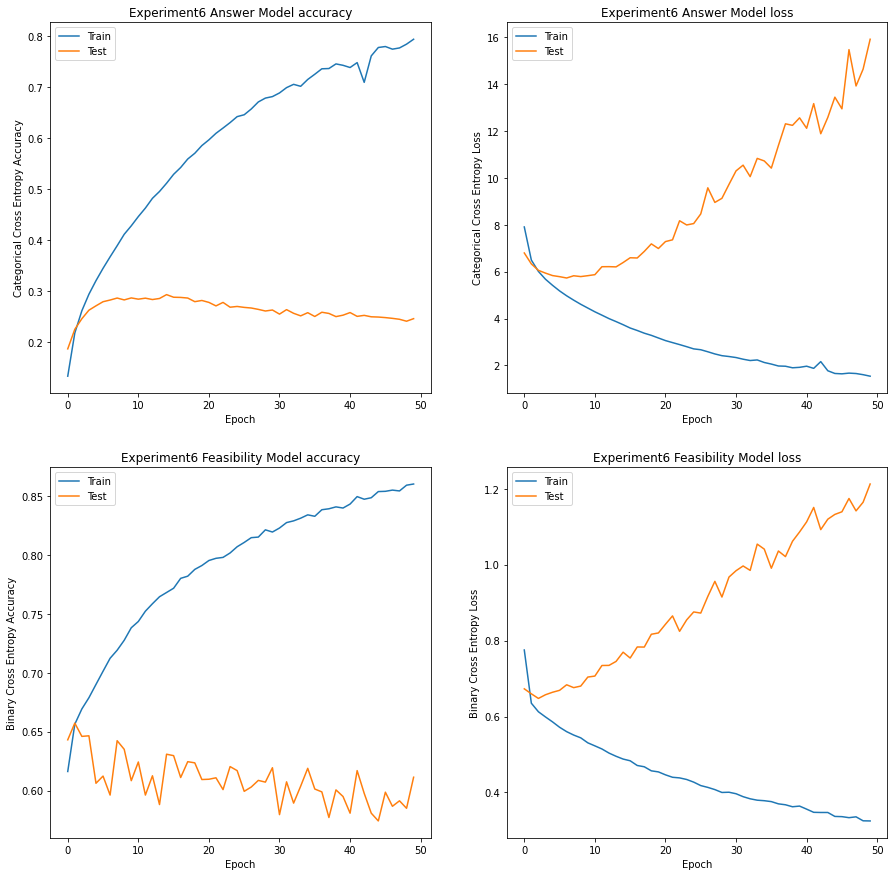

In [51]:
plot_experiments(6)

In [15]:
inference_feasibility_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
feasibilityQuestion_Input (Inpu [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_op_layer_Identity (TensorFlo [(None, 128)]        0           feasibilityQuestion_Input[0][0]  
__________________________________________________________________________________________________
tf_op_layer_ExpandDims (TensorF [(None, 1, 128)]     0           tf_op_layer_Identity[0][0]       
__________________________________________________________________________________________________
tf_op_layer_ExpandDims_1 (Tenso [(None, 1, 128)]     0           feasibilityQuestion_Input[0][0]  
______________________________________________________________________________________________

In [16]:
inference_encoder_model.summary()

Model: "encoder_module"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Context_Embedding (Embedding multiple                  8870200   
_________________________________________________________________
Context_Bid_Layer0 (Bidirect multiple                  102144    
_________________________________________________________________
Context_Bid_Layer1 (Bidirect multiple                  74496     
_________________________________________________________________
batch_normalization (BatchNo multiple                  512       
_________________________________________________________________
batch_normalization_1 (Batch multiple                  512       
_________________________________________________________________
Question_Embedding (Embeddin multiple                  8870200   
_________________________________________________________________
Question_Bid_Layer0 (Bidirec multiple               

In [17]:
inference_answer_model.summary()

Model: "answer_module"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              multiple                  16512     
_________________________________________________________________
dense_4 (Dense)              multiple                  16512     
Total params: 33,024
Trainable params: 33,024
Non-trainable params: 0
_________________________________________________________________
